In [44]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import torch.nn.functional as F
import torch
from torch import Tensor as TT
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict
from glob import glob
import os
import os.path
import pathlib
from typing import Any, Callable, Optional, Sequence, Tuple, Union
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
mratings = pd.read_csv('/home/giangi/Workspace/Data/ml-100k/u.data', sep='\t', header=None)
columns=['user_id','movie_id','rating','timestamp']
mratings.columns = columns
rating_ugrp = mratings.groupby('user_id')['rating']
rating_mgrp = mratings.groupby('movie_id')['rating']
urating_cnt = rating_ugrp.count()
urating_cnt.describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

In [25]:
mrating_cnt = rating_mgrp.count()
mrating_cnt.describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64

In [26]:
urating_avg = rating_ugrp.mean()
urating_avg.describe()

count    943.000000
mean       3.588191
std        0.445233
min        1.491954
25%        3.323054
50%        3.620690
75%        3.869565
max        4.869565
Name: rating, dtype: float64

In [38]:
mrating_avg = rating_mgrp.mean()
mrating_avg.describe()

count    1682.000000
mean        3.076045
std         0.781662
min         1.000000
25%         2.659600
50%         3.161528
75%         3.653428
max         5.000000
Name: rating, dtype: float64

In [403]:
#get the indices for users and movies. Make is zero base since they start from 1
indices = mratings[['user_id','movie_id']].values - 1
#shuffle the indices to create train and validation sets
indx = np.arange(indices.shape[0])
np.random.shuffle(indx)
split_percent = 0.8
split_train = int(round(split_percent*indx.size))
indx_train = TT(indices[indx[:split_train]]).int()
indx_val = TT(indices[indx[-(indx.size - split_train):]]).int()
rate_train_orig = mratings['rating'].values.astype(float)[indx[:split_train]]
rate_train = TT(rate_train_orig)
avg_rate = rate_train.mean()
rate_train -= avg_rate
rate_val_orig = mratings['rating'].values.astype(float)[indx[-(indx.size - split_train):]]
rate_val = TT(rate_val_orig)
rate_val -= avg_rate#remove the train mean

In [404]:
#sanity check
all_good = True
for _ in range(1000):
    i = np.random.randint(len(indx_train))
    indx_now = indx_train[i].numpy()
    if rate_train_orig[i] != mratings.loc[(mratings['user_id'] - 1 == indx_now[0]) & (mratings['movie_id'] - 1 == indx_now[1])]['rating'].values[0]:
        all_good = False
all_good

True

In [405]:
class CFLoss(nn.Module):
    def __init__(self,lambda_g,lambda_r):
        super().__init__()
        self.lambda_g = lambda_g
        self.lambda_r = lambda_r
    def forward(self,ratings,iuemb,imemb,indices_um,print_l=False):
        uemb = iuemb.weight
        memb = imemb.weight
        approx = torch.matmul(uemb,memb.T)
        #MSE loss
        loss = ((approx[indices_um[:,0],indices_um[:,1]] - ratings)*(approx[indices_um[:,0],indices_um[:,1]] - ratings)).mean()
        #L2 regularization loss 
        lossr = self.lambda_r*((uemb*uemb).sum()/uemb.shape[0] + (memb*memb).sum()/memb.shape[0])
        #Gravity loss 1/(num_users*num_movies)sum_{i,j}(<uemb_i,memb_j>**2)
        lossg = self.lambda_g*(approx*approx).sum()/(uemb.shape[0]*memb.shape[0])
        if print_l:
            print('Losses',loss.item(),lossr.item(),lossg.item())
        return loss + lossr + lossg

#Collaborative FilteringModel
class CFModel(nn.Module):
    def __init__(self, num_users, num_movies, emb_size):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.movie_emb = nn.Embedding(num_movies, emb_size)
    
    def forward(self):
        return self.user_emb,self.movie_emb
#Test loss
# nemb = 100
# uemb = nn.Embedding(nusers,nemb)
# memb = nn.Embedding(nmovies,nemb)
# lambda_g = 0.1
# lambda_r = 0.1
# cfloss = CFLoss(lambda_g,lambda_r)
# cfloss(rate_train,uemb,memb,indx_train)
        
        

In [406]:
device = 'cuda'
num_users,num_movies = urating_avg.shape[0],mrating_avg.shape[0]
emb_size = 100
model = CFModel(num_users,num_movies,emb_size).to(device)
lr = 0.1
base_lr = 0.001
max_lr = 0.1
step_size_up = 10
gamma_sch = .9
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,step_size_up=step_size_up,mode="exp_range",gamma=gamma_sch,cycle_momentum=False)
lambda_g = 0.1
lambda_r = 0.1
cfloss = CFLoss(lambda_g,lambda_r)

nepochs = 20000
print_every = 200
rate_train_d = rate_train.to(device)
indx_train_d = indx_train.to(device)
rate_val_d = rate_val.to(device)
indx_val_d = indx_val.to(device)
model.train(True)
for j in range(nepochs):
    running_loss = 0.
    last_loss = 0.
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    uemb,memb = model()

    # Compute the loss and its gradients
    loss = cfloss(rate_train_d,uemb,memb,indx_train_d).to(device)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    last_loss = loss.item()
    if j % print_every == 0:
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            uemb,memb = model()
            loss = cfloss(rate_val_d,uemb,memb,indx_val_d).to(device)
            print(f'epoch {j} train loss: {last_loss}, validation loss: {loss.item()}')

        model.train(True)
        # tb_x = epoch_index * len(training_loader) + i + 1
        # tb_writer.add_scalar('Loss/train', last_loss, tb_x)

epoch 0 train loss: 132.14630126953125, validation loss: 128.67214965820312
epoch 200 train loss: 65.02436828613281, validation loss: 86.82623291015625
epoch 400 train loss: 37.82575607299805, validation loss: 64.00396728515625
epoch 600 train loss: 24.750581741333008, validation loss: 49.43120193481445
epoch 800 train loss: 17.670337677001953, validation loss: 39.126953125
epoch 1000 train loss: 13.431842803955078, validation loss: 31.41851234436035
epoch 1200 train loss: 10.658334732055664, validation loss: 25.492446899414062
epoch 1400 train loss: 8.70393180847168, validation loss: 20.871726989746094
epoch 1600 train loss: 7.24589729309082, validation loss: 17.233121871948242
epoch 1800 train loss: 6.111804962158203, validation loss: 14.34273910522461
epoch 2000 train loss: 5.2030229568481445, validation loss: 12.027565002441406
epoch 2200 train loss: 4.459357738494873, validation loss: 10.15849781036377
epoch 2400 train loss: 3.8418710231781006, validation loss: 8.638641357421875
e

In [318]:
#Read in the list of movies with title and genre colums 5 to 23 with 1 if of that genre
df_item = pd.read_csv('/home/giangi/Workspace/Data/ml-100k/u.item',sep='|',header=None,encoding='latin-1')
#Read the mapping of the columns 5 to 25 to genre name
df_genre_str = pd.read_csv('/home/giangi/Workspace/Data/ml-100k/u.genre',sep='|',header=None,encoding='latin-1')

In [443]:
df_item

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [444]:
df_genre_str

,0,1
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [327]:
sel = [1]
sel.extend(list(range(5,24)))
i_genre = list(range(5,24))
#select only the movie name and the gernes from df_item
df_genre = df_item[sel]
#get just one of the genre per move. Get the underlaying matrix of just movie genre
dt_genre = df_genre[i_genre].values
#get the index sorting along genre. The ones will always be last so get the index of last elemtent
col_gen = dt_genre.argsort(1)[:,-1]
#Make sure only ones were selected
np.unique(dt_genre[np.arange(len(col_gen)),col_gen])

array([1])

In [322]:
df_genre

,1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,Mat' i syn (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,B. Monkey (1998),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,Sliding Doors (1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,You So Crazy (1994),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [373]:
df_genre_str

,0,1
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [445]:
#col_gen cotains the numerical value of the genre which is also the index in df_genre_str. Select for each movie the genre name and numerical value from
#df_genre_str and concatenate the actual name of the movie
df_movie_genre = pd.concat([df_genre_str.loc[col_gen].reset_index(drop=True),df_genre[1]],axis=1,ignore_index=True)
df_movie_genre

,0,1,2
0,Animation,3,Toy Story (1995)
1,Thriller,16,GoldenEye (1995)
2,Thriller,16,Four Rooms (1995)
3,Drama,8,Get Shorty (1995)
4,Drama,8,Copycat (1995)
...,...,...,...
1677,Drama,8,Mat' i syn (1997)
1678,Thriller,16,B. Monkey (1998)
1679,Drama,8,Sliding Doors (1998)
1680,Comedy,5,You So Crazy (1994)


In [453]:
#Group by the numerical values of the genre and get the mapping of each group, what elements belong to it
movie_indx = df_movie_genre.groupby(1).indices
for k,v in movie_indx.items():
    print(k,len(v),df_genre_str.loc[k].values)

0 2 ['unknown' 0]
1 123 ['Action' 1]
2 39 ['Adventure' 2]
3 31 ['Animation' 3]
4 26 ["Children's" 4]
5 235 ['Comedy' 5]
6 17 ['Crime' 6]
7 46 ['Documentary' 7]
8 695 ['Drama' 8]
9 22 ['Fantasy' 9]
10 3 ['Film-Noir' 10]
11 43 ['Horror' 11]
12 12 ['Musical' 12]
13 13 ['Mystery' 13]
14 119 ['Romance' 14]
15 23 ['Sci-Fi' 15]
16 201 ['Thriller' 16]
17 5 ['War' 17]
18 27 ['Western' 18]


In [446]:
#use tsne to do dimentionality reduction
from sklearn.manifold import TSNE
X = model.movie_emb.weight.detach().cpu().numpy()
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=3).fit_transform(X)

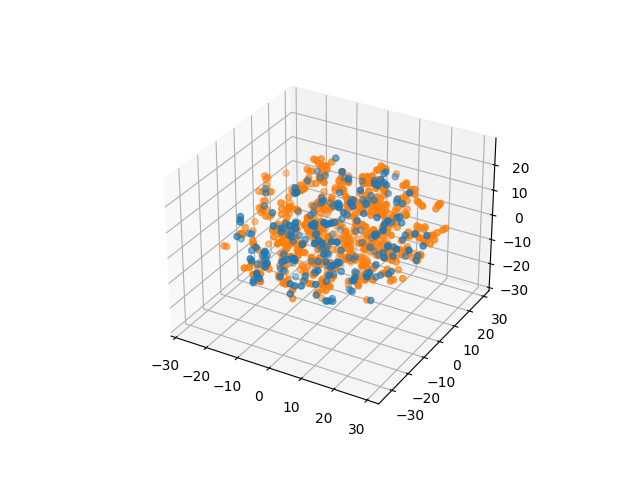

In [455]:
#pick two genres that should not overlap like documentary and horror (7,11) or comedy and drama (5,8)
#Rotate to see if there is a view angle that shows one color more than the other
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mark = ['o','^']
which = [5,8]
i = 0
for (k,v) in movie_indx.items():
    if k in which:
        ax.scatter(X_embedded[v,0],X_embedded[v,1],X_embedded[v,2],mark[i])
        i += 1

In [412]:
#Some manual verification to make sure the results are correct
iuemb,imemb = model()
uemb = iuemb.weight
memb = imemb.weight
#get the factorized matrix
approx = torch.matmul(uemb,memb.T).detach().cpu().numpy()

In [431]:
#from the validation set get the ones  whose predicted rating and < .5 from the truth
sel = np.where(np.abs(approx[indx_val[:,0],indx_val[:,1]] - rate_val.numpy()) < .5)
indx_good = indx_val[sel].numpy()

In [441]:
#check that the difference is less than .5. Need to add back the avg_rate to compare
np.abs(mratings.loc[indx[-(indx.size - split_train):][sel]]['rating'] - (approx[indx_good[:,0],indx_good[:,1]] + avg_rate.numpy())).max()

0.4999368190765381